In [0]:
import numpy as np
import pandas as pd

In [0]:
#Single gene methods


#unweighted
def mse(preds,targets):
  first_pad=len(targets)
  return np.mean((preds[:first_pad]-targets)**2)

def mseXL(preds,targets):
  upto=len(preds)
  return np.mean((preds-targets[:upto])**2)

#returns a list of all absolute errors at positions that are splice sites. Meant to assess how well the regression is doing
def abs_errors_for_gene_ss(preds,targets):
  error_list=[]
  nonzero_targets = np.nonzero(targets)[0]
  for index in nonzero_targets:
    abs_error = np.abs(preds[index]-targets[index])
    error_list.append(abs_error)
  return error_list



#only returns num_ss and number of those that were predicted. Accuracy computation only at end
def count_topk(preds,targets):
  preds = preds[:len(targets)]
  nonzero_targets = np.nonzero(targets)[0]
  num_ss = len(nonzero_targets)
  topk_preds = np.argsort(preds)[-num_ss:]
  #topk_preds = np.argsort(preds)[:num_ss]
  identified_ss =0
  for p in topk_preds:
    if p in nonzero_targets:
      identified_ss+=1
  return num_ss,identified_ss


def forgiving_topk(preds,targets,grace_window=3):
  preds = preds[:len(targets)]
  nonzero_targets = np.nonzero(targets)[0]
  num_ss = len(nonzero_targets)
  topk_preds = np.argsort(preds)[-num_ss:]
  identified_ss =0
  for p in topk_preds:
    for augmented_p in range(p-grace_window,p+grace_window):
      if augmented_p in nonzero_targets:
        identified_ss+=1
  return num_ss,identified_ss



In [0]:
#Multigene methods

#want a threshhold where splice sites are predicted with frequency 1/165 (1/1000 bp)
def find_correct_threshold(all_preds,th):
  total_ss =0
  total_hexamers=0
  for p in all_preds:
    np_preds = np.array(p)
    total_hexamers+=len(np_preds)
    total_ss+=len(np.where(np_preds>th)[0])
  print(total_ss)
  print(total_ss/total_hexamers)

#will calculate mse for all genes and also build array of 
def mse_by_gene_length(all_preds,all_targets):
  errors=[]
  lengths=[]
  num_samples = len(all_preds)
  for i in range(num_samples):
    p = all_preds[i]
    t = all_targets[i]
    if(len(p)==len(t)):
      lengths.append(len(p))
      errors.append(mseXL(p,t))
  return errors,lengths


def top_k_accuracy(all_preds,all_targets):
  total_ss=0
  predicted_ss=0
  for i in range(len(all_preds)):
    p= all_preds[i]
    t=all_targets[i]
    #ts,ps = forgiving_topk(p,t,10)
    ts,ps = count_topk(p,t)
    total_ss+=ts
    predicted_ss+=ps
  print(predicted_ss/total_ss)

def mae(all_preds,all_targets):
  total_errors=[]
  for i in range(len(all_targets)):
    p = all_preds[i]
    t = all_targets[i]
    total_errors.extend(abs_errors_for_gene_ss(p,t))
  total_errors = np.array(total_errors)
  return np.mean(total_errors,0)







In [4]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [5]:

!pip3 install torch
!pip3 install transformers
import torch
from transformers import BertTokenizer, BertModel, BertForTokenClassification, BertConfig
from transformers import TransfoXLTokenizer, TransfoXLModel, TransfoXLConfig
from keras.preprocessing.sequence import pad_sequences
import sys

     |████████████████████████████████| 368kB 2.8MB/s 
     |████████████████████████████████| 675kB 47.5MB/s 
     |████████████████████████████████| 860kB 39.3MB/s 
     |████████████████████████████████| 1.0MB 35.0MB/s 
  Created wheel for regex: filename=regex-2019.12.9-cp36-cp36m-linux_x86_64.whl size=609189 sha256=0ae40311ba29395179cae4b4eca5cf0117abbc8df8d630de3484cb5bd3f4d8f6
  Stored in directory: /root/.cache/pip/wheels/0d/fb/b3/a89169557229468c49ca64f6839418f22461f6ee0a74f342b1
  Created wheel for sacremoses: filename=sacremoses-0.0.35-cp36-none-any.whl size=883999 sha256=69c352645777b7c970c913507af321aac065029e75b05e32d2c93479cd7ace10
  Stored in directory: /root/.cache/pip/wheels/63/2a/db/63e2909042c634ef551d0d9ac825b2b0b32dede4a6d87ddc94
Successfully built regex sacremoses


Using TensorFlow backend.


In [0]:

class BertForTokenRegression(torch.nn.Module):
  def __init__(self):
    super(BertForTokenRegression, self).__init__()
    self.config = BertConfig(vocab_size_or_config_json_file='/content/drive/My Drive/regression_bert_configuration.json')
    self.config.vocab_size=6099
    self.bert = BertForTokenClassification(self.config)
    self.linear = torch.nn.Linear(self.config.hidden_size, 1)
  def forward(self, input_ids, attention_mask=None):
    scores, hidden_states, att_weights = self.bert(input_ids,attention_mask=attention_mask)
    #print(hidden_states[8].size())
    #print(scores.size())
    preds = self.linear(hidden_states[8]).squeeze(0).squeeze(1)
    #preds = self.softmax(linear_out).squeeze(0)
    return preds, att_weights


class Model(torch.nn.Module):
  def __init__(self):
    super(Model, self).__init__()
    self.config = TransfoXLConfig(vocab_size_or_config_json_file='/content/drive/My Drive/classification_XL_configuration.json')
    self.config.vocab_size=204098
    #self.config=TransfoXLConfig(vocab_size_or_config_json_file=204098,n_heads=8,n_layers=6,adaptive=False,tgt_len=1012,mem_len=1012)
    self.model = TransfoXLModel(self.config)
    self.out_layer = torch.nn.Linear(self.model.d_model, 1)
  def forward(self, input_ids, mems=None):
    hidden_states, mems = self.model(input_ids, mems)
    preds = self.out_layer(hidden_states[0]).squeeze(0).squeeze(1)
    return preds, mems



In [0]:
def read_split_file(filepath):
  print("reading ",filepath)
  genes = []
  labels = []
  df = pd.read_csv(filepath,usecols=[2,3],sep="\t",skiprows=1,header=None)
  print(df.head())
  for entry in df.itertuples():
    kmer_list = [kmer.strip("\'") for kmer in entry[1][1:-1].split(", ")]
    #for some reason there are empty examples in here
    if(len(kmer_list)>1):
      label_list = list(map(float, entry[2][1:-1].split(", ")))
      genes.append(kmer_list)
      labels.append(label_list)
  return genes, labels

def tokenize_and_pad_samples(genes,labels):
  kmer_filepath = '/content/drive/My Drive/hexamers.txt'
  formatted_samples = [['[CLS]']  + sample + ['[SEP]'] for sample in genes]
  formatted_labels = [[0] + l + [0] for l in labels]
  tokenizer = BertTokenizer(kmer_filepath, max_len=MAX_LEN)
  print("TOKENIZER LENGTH", len(tokenizer))
  attention_masks = [np.concatenate([np.ones(len(l)), np.zeros(MAX_LEN - len(l))]) for l in formatted_labels]
  seq_ids = [tokenizer.convert_tokens_to_ids(sample) for sample in formatted_samples]
  seq_ids = pad_sequences(seq_ids, maxlen=MAX_LEN, truncating='post', padding='post')
  return seq_ids, attention_masks, formatted_labels


def read_data(filepath):
  print("reading ",filepath)
  genes = []
  labels = []
  df = pd.read_csv(filepath,usecols=[1,2],sep="\t",skiprows=1,header=None,nrows=1000)
  print(df.head())
  for entry in df.itertuples():
    kmer_list = [kmer.strip("\'") for kmer in entry[1][1:-1].split(", ")]
    label_list = list(map(float, entry[2][1:-1].split(", ")))
    genes.append(kmer_list)
    labels.append(label_list)
  return genes, labels
	

def tokenize_samples(genes):
  k= len(genes[0][0])
  if k==2:
    kmer_filepath = '/content/drive/My Drive/fourmersXL.txt'
  elif k==6:
    kmer_filepath = '/content/drive/My Drive/hexamersXL.txt'

  tokenizer=TransfoXLTokenizer(vocab_file=kmer_filepath)
  print("TOKENIZER LENGTH", len(tokenizer))
  seq_ids = [tokenizer.convert_tokens_to_ids(gene) for gene in genes]
  
  return seq_ids

In [0]:
#For BERT
MAX_LEN=1002
genes,labels = read_split_file('/content/drive/My Drive/Whole_Brain_val.txt')
seq_ids, masks, labels = tokenize_and_pad_samples(genes,labels)
print("Read in data")

reading  /content/drive/My Drive/Whole_Brain_val.txt


ValueError: ignored

In [8]:
#For XL
window_size = 1012
genes,labels = read_data('/content/drive/My Drive/Whole_Brain_test.txt')
seq_ids= tokenize_samples(genes)
print("Read in data")
print(len(seq_ids))

reading  /content/drive/My Drive/Whole_Brain_test.txt
                                                   1                                                  2
0  ['AGCTGG', 'CGCCAT', 'CGCGCA', 'CCCTCT', 'CAGG...  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
1  ['CGGACC', 'CCGGAA', 'GCCCGC', 'GGCAGC', 'GCGC...  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
2  ['GTCTGT', 'AGGTTA', 'AGGGAG', 'AAGATG', 'GCGG...  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
3  ['CTCGTT', 'TGCGAT', 'GTTCCG', 'TTATCT', 'GGAT...  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
4  ['GCCCAT', 'TGGCTG', 'CGAGAG', 'GCCGGT', 'GCGG...  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
TOKENIZER LENGTH 4098
Read in data
1000


In [9]:
#XL
device = torch.device('cuda')
#building model
model = Model()
model.to(device)
f="/content/drive/My Drive/adipose_6e.pt"
model.load_state_dict(torch.load(f))

<All keys matched successfully>

In [0]:
#BERT
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BertForTokenRegression()
model.to(device)
f="/content/drive/My Drive/brain_bert_weights.pt"
model.load_state_dict(torch.load(f))


<All keys matched successfully>

In [0]:


def get_all_preds(input_ids,masks):
  model.eval()
  num_samples=len(input_ids)
  eval_loss=0
  model_preds=[]
  att_weight_list=[]
  for curr in range(num_samples):
    curr_sample = torch.tensor(input_ids[curr]).unsqueeze(0).long().cuda()
    curr_masks = torch.tensor(masks[curr]).unsqueeze(0).long().cuda()
    with torch.no_grad():
      predictions, att_weights = model(curr_sample, attention_mask=curr_masks)
      model_preds.append(predictions.detach().cpu().numpy())
      #att_weight_list.append(att_weights[7].detach().cpu().numpy())
    if(curr%500==0):
      print(curr)
  return model_preds


def get_list_of_mse(input_ids,masks,labels):
  model.eval()
  num_samples=len(input_ids)
  eval_loss=0
  mse_list=[]
  identified_ss=0
  all_ss=0
  for curr in range(num_samples):
    curr_sample = torch.tensor(input_ids[curr]).unsqueeze(0).long().cuda()
    curr_masks = torch.tensor(masks[curr]).unsqueeze(0).long().cuda()
    curr_label = np.array(labels[curr])
    with torch.no_grad():
      predictions, att_weights = model(curr_sample, attention_mask=curr_masks)
      np_preds = predictions.detach().cpu().numpy()
      mse_list.append(mse(np_preds,curr_label))
      ss_in_gene, found_ss = count_topk(np_preds,curr_label)
      all_ss+=ss_in_gene
      identified_ss+=found_ss
    if(curr%500==0):
      print(curr)
      print(all_ss)
      print(identified_ss)
  return mse_list, all_ss, identified_ss


def get_all_predsXL(genes):
  num_samples=len(genes)
  all_preds=[]
  for i in range(num_samples):
    if(i%100==0):
      print(i)
    mems = None
    curr_gene = genes[i]
    curr_labels = labels[i]
    curr_gene_preds=[]
    #looping over all windows
    for w in range(0, len(curr_gene), window_size):
      toks = curr_gene[w:w+window_size]
      #ignore tiny windows(leads to dimensionality issues)
      if(len(toks)<2):
        continue
      window_input_ids = torch.tensor(toks).unsqueeze(0).cuda()
      window_labels = torch.tensor(curr_labels[w:w+window_size]).long().cuda()
      with torch.no_grad():
        window_preds, mems = model(window_input_ids, mems)
      curr_gene_preds = curr_gene_preds+list(window_preds.detach().cpu().numpy())
    all_preds.append(curr_gene_preds)
  return all_preds


In [11]:
#mse_list, all_ss, identified_ss = get_list_of_mse(seq_ids[:4000],masks[:4000],labels[:4000])
xl_preds = get_all_predsXL(seq_ids)

0
100
200
300
400
500
600
700
800
900


In [0]:

errors,lengths=mse_by_gene_length(xl_preds,[np.array(l) for l in labels])

In [13]:

mse_arr = np.array(errors)
mean_mse = np.mean(mse_arr)
std_mse = np.std(mse_arr)
print(mean_mse)
print(std_mse)

0.01422733574839127
0.00439977550785332


In [14]:
top_k_accuracy(xl_preds,[np.array(l) for l in labels])
print(mae(xl_preds,labels))

0.16365070527097253
0.3622863702721019


In [0]:
find_correct_threshold(xl_preds,0.49)


29228
0.005981187540352245


Results on Validation Set:

Brain: 0.0645,0.0192,0.275 Threshold where SS occur at freq 1/165 = 0.91 Actual topK=0.149, MAE=0.375

Adipose: 0.014,0.0040,0.272, Threshold = 0.49 Actual topK =0.145 MAE =0.40

Thyroid: 0.0346,0.0113,0.282, Threshold = 0.74 Actual topK 0.166 MAE = 0.36

Adipose Model on Brain: 0.014,0.004,0.275 Actual topK=0.146, MAE=0.37

Thyroid Model on Brain: 0.0345,0.0111,0.287  Actual topK=0.167 MAE = 0.356

Thryoid Model on Adipose: 0.0345,0.0112,0.287 Actual topK=0.168 MAE = 0.364

Brain Model on Adipose: 0.065,0.0197,0.275 Actual topK=0.148 MAE = 0.375

Thyroid 2mer 0.0267,0.004, 0.114, Threshold = 0.67

NEW TRAINING:

Brain 6e :0.174

Brain 6e ft: 0.16

Adipose 6e 0.158

Adipose 6e ft 0.16 worse MAE

Brain 6e on Adipose: 0.176

Adipose 6e on Brain: 0.164


Text(0, 0.5, 'MSE')

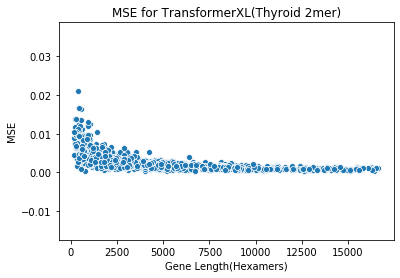

In [0]:
sns.scatterplot(lengths,errors)
plt.title("MSE for TransformerXL(Thyroid 2mer)")
plt.xlabel("Gene Length(Hexamers)")
plt.ylabel("MSE")

<function matplotlib.pyplot.show>

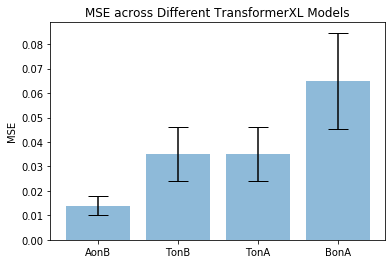

In [0]:
#ViZ!
import matplotlib.pyplot as plt
import seaborn as sns
#means=[0.0289,0.042,0.0187,0.0169]
#devs=[0.0149,0.0047,0.0207,0.0028]
#tissues=["Adipose","Thyroid","Brain","Brain(XL)"]
means=[0.014,0.035,0.035,0.065]
devs=[0.004,0.011,0.011,0.0197]
tissues=["AonB","TonB","TonA","BonA"]
x_pos = np.arange(len(tissues))
g=plt.bar(x_pos, means, yerr=devs, align='center', alpha=0.5, ecolor='black', capsize=10)
plt.ylabel('MSE')
plt.xticks(x_pos,tissues)
plt.title('MSE across Different TransformerXL Models')
plt.show

<function matplotlib.pyplot.show>

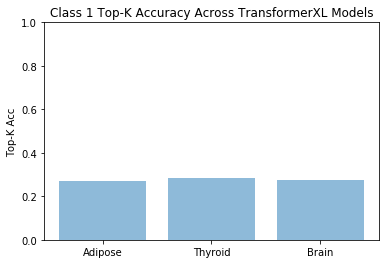

In [0]:
#ViZ!
import matplotlib.pyplot as plt
import seaborn as sns
#means=[0.0289,0.042,0.0187,0.0169]
#devs=[0.0149,0.0047,0.0207,0.0028]
#tissues=["Adipose","Thyroid","Brain","Brain(XL)"]
accs=[0.272,0.282,0.275]
tissues=["Adipose","Thyroid","Brain"]
x_pos = np.arange(len(tissues))
g=plt.bar(x_pos, accs, align='center', alpha=0.5, ecolor='black', capsize=10)
plt.ylabel('Top-K Acc')
plt.ylim(0.0,1.0)
plt.xticks(x_pos,tissues)
plt.title('Class 1 Top-K Accuracy Across TransformerXL Models')
plt.show

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


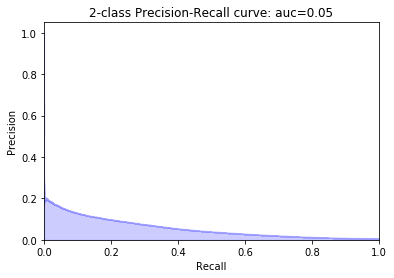

In [0]:
from sklearn.metrics import precision_recall_curve
from inspect import signature
from sklearn.metrics import f1_score
from sklearn.metrics import auc
def plot_AUCPRC(labels, predictions):
	"""labels: a 1d list of all the labels (0 or 1) for our samples
		predictions: a 1d list of all the probabilities (between 0 and 1)
		             for each one of our samples. It should be the probability that
		             that this sample belongs to the second class (e.g a splice site.)
	"""
	# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument\
	precision, recall, _ = precision_recall_curve(labels, predictions)
	aucScore = auc(recall, precision)
	step_kwargs = ({'step': 'post'}
	               if 'step' in signature(plt.fill_between).parameters
	               else {})
	plt.step(recall, precision, color='b', alpha=0.2,
	         where='post')
	plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

	plt.xlabel('Recall')
	plt.ylabel('Precision')
	plt.ylim([0.0, 1.05])
	plt.xlim([0.0, 1.0])
	plt.title('2-class Precision-Recall curve: auc={0:0.2f}'.format(aucScore))
 
flat_preds = []
flat_labels = []
for i in range(len(labels)):
  p = xl_preds[i]
  l= labels[i][:len(p)]
  flat_preds.extend(p)
  flat_labels.extend([1 if item>0 else 0 for item in l])
print(flat_labels[:100])
plot_AUCPRC(flat_labels,flat_preds)